In [1]:
#set up environment
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization

# create directories for the notebook. DO NOT change
data_dir = 'data/07_Functional_analysis'
!data_dir = 'data/07_Functional_analysis'

!mkdir -p data
!mkdir -p $data_dir

# fetches useful files for the current notebook. All files will be saved in $data_dir
!wget 'https://polybox.ethz.ch/index.php/s/WaSKZs2E5xn9SHm/download' -O data/Download.zip
!unzip -o data/Download.zip -d data
!rm data/Download.zip

/usr/bin/sh: line 1: data_dir: command not found
--2025-12-13 16:51:51--  https://polybox.ethz.ch/index.php/s/WaSKZs2E5xn9SHm/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data/Download.zip’

data/Download.zip       [        <=>         ] 310.65M   219MB/s    in 1.4s    

2025-12-13 16:51:52 (219 MB/s) - ‘data/Download.zip’ saved [325735603]

Archive:  data/Download.zip
   creating: data/07_Functional_analysis/Euler_scripts/
 extracting: data/07_Functional_analysis/Euler_scripts/annotate_bacteria_95.sh  
 extracting: data/07_Functional_analysis/Euler_scripts/gunc_bacteria_95.sh  
 extracting: data/07_Functional_analysis/Euler_scripts/q2_gunc_db.sh  
 extracting: data/07_Functional_analysis/Euler_scripts/rgi_bacteria_95.sh  
   creating: data/07_Functional_analysis/data/
 extracting: da

In [7]:
!mkdir -p exported/caz_ft

!qiime tools export \
  --input-path data/07_Functional_analysis/data/caz_annot_ft_bacteria_95.qza \
  --output-path exported/caz_ft

!biom convert \
  -i exported/caz_ft/feature-table.biom \
  -o exported/caz_ft/feature-table.tsv \
  --to-tsv


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Exported data/07_Functional_analysis/data/caz_annot_ft_bacteria_95.qza as BIOMV210DirFmt to directory exported/caz_ft


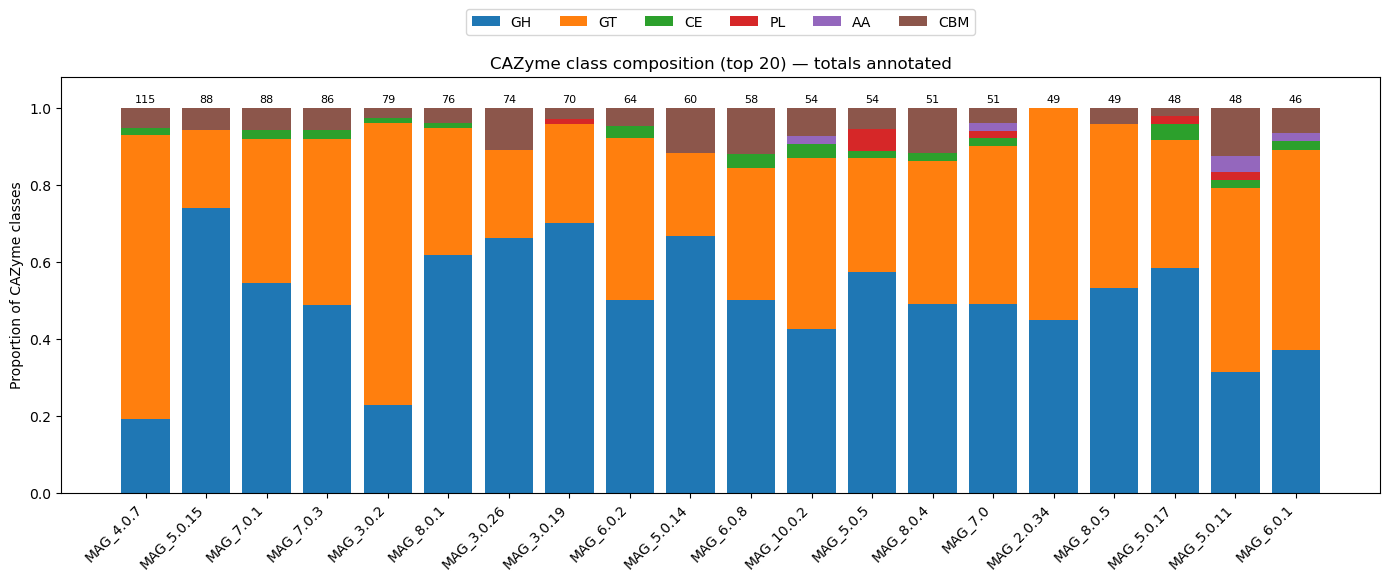

Saved: figures/cazy_class_stackedbar_topMAGS.png


,cazy_total
4.0.7,115.0
5.0.15,88.0
7.0.1,88.0
7.0.3,86.0
3.0.2,79.0
8.0.1,76.0
3.0.26,74.0
3.0.19,70.0
6.0.2,64.0
5.0.14,60.0


In [10]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline

TSV = Path("exported/caz_ft/feature-table.tsv")
OUT_DIR = Path("figures"); OUT_DIR.mkdir(exist_ok=True, parents=True)

def cazy_class(feature_id: str):
    m = re.match(r"^(GH|GT|CE|PL|AA|CBM)\d+", str(feature_id).strip(), flags=re.I)
    return m.group(1).upper() if m else "Other"

# 1) 读 TSV（跳过 biom 导出的注释行）
df = pd.read_csv(TSV, sep="\t", comment="#")
df = df.set_index(df.columns[0])

# 只保留数值矩阵：features x columns(通常是MAG或样本)
mat = df.apply(pd.to_numeric, errors="coerce").fillna(0)

# 如果你发现“列看起来像 CAZ family、行像MAG”，就转置一下：
#   print(list(mat.index[:5]), list(mat.columns[:5]))
#   mat = mat.T

# 2) 汇总到 CAZy 大类：class x MAG
classes = pd.Series(mat.index, index=mat.index).map(cazy_class)
class_sum = mat.groupby(classes).sum()

# 3) 组成比例（composition）
class_prop = class_sum / class_sum.sum(axis=0).replace(0, np.nan)

# 4) 选 CAZyme 总量最高的前 N 个来画
N = 20  # PPT建议 15~20
top_mags = class_sum.sum(axis=0).sort_values(ascending=False).head(N).index
plot_prop = (class_prop[top_mags].T).fillna(0)   # MAG x class
totals = class_sum[top_mags].sum(axis=0)         # 每个 MAG 的总 CAZ

plt.figure(figsize=(14, 6))
bottom = np.zeros(plot_prop.shape[0])
x = np.arange(plot_prop.shape[0])

order = [c for c in ["GH","GT","CE","PL","AA","CBM","Other"] if c in plot_prop.columns]
for cls in order:
    plt.bar(x, plot_prop[cls].values, bottom=bottom, label=cls)
    bottom += plot_prop[cls].values

# 在柱子顶端标注总量
for i, mag in enumerate(plot_prop.index):
    plt.text(i, 1.01, f"{int(totals[mag])}", ha="center", va="bottom", fontsize=8, rotation=0)

plt.xticks(x, [f"MAG_{m}" for m in plot_prop.index], rotation=45, ha="right")
plt.ylim(0, 1.08)
plt.ylabel("Proportion of CAZyme classes")
plt.title(f"CAZyme class composition (top {N}) — totals annotated")
plt.legend(ncols=7, bbox_to_anchor=(0.5, 1.18), loc="upper center")
plt.tight_layout()

plt.savefig("figures/cazy_class_composition_topN_annotated.svg")
plt.savefig("figures/cazy_class_composition_topN_annotated.pdf")
plt.show()

print("Saved:", out)

# 附：Top MAG 列表（按 CAZyme 总量）
display(class_sum.sum(axis=0).sort_values(ascending=False).head(20).to_frame("cazy_total"))


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported data/07_Functional_analysis/data/caz_annot_ft_bacteria_95.qza as BIOMV210DirFmt to directory exported/caz_ft
Matrix shape (features x UUIDs): (102, 170)
Example UUID columns: ['009d5f9a-be92-4328-b5ad-68d282a94e3b', '0174159a-d8ba-4d10-995d-c9dddd2a0b48', '01b54364-1bbb-43e7-9366-a931641ff6cd', '033e4bc6-2e06-4d36-a408-30aae536885c', '03727db6-e5bc-48a7-8dd0-01ef817cde25']


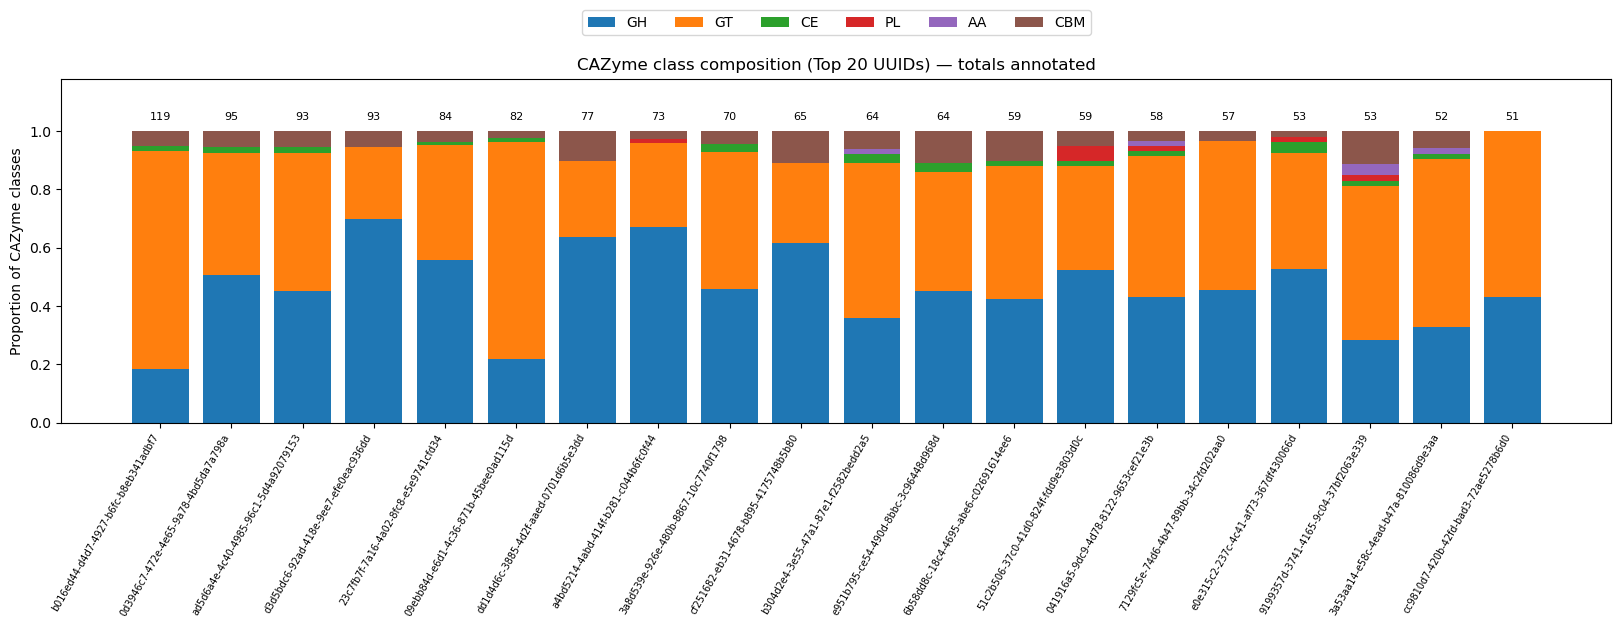

Saved: figures/cazy_class_top20_uuid_prop_annot.pdf
Saved: figures/cazy_class_top20_uuid_prop_annot.svg


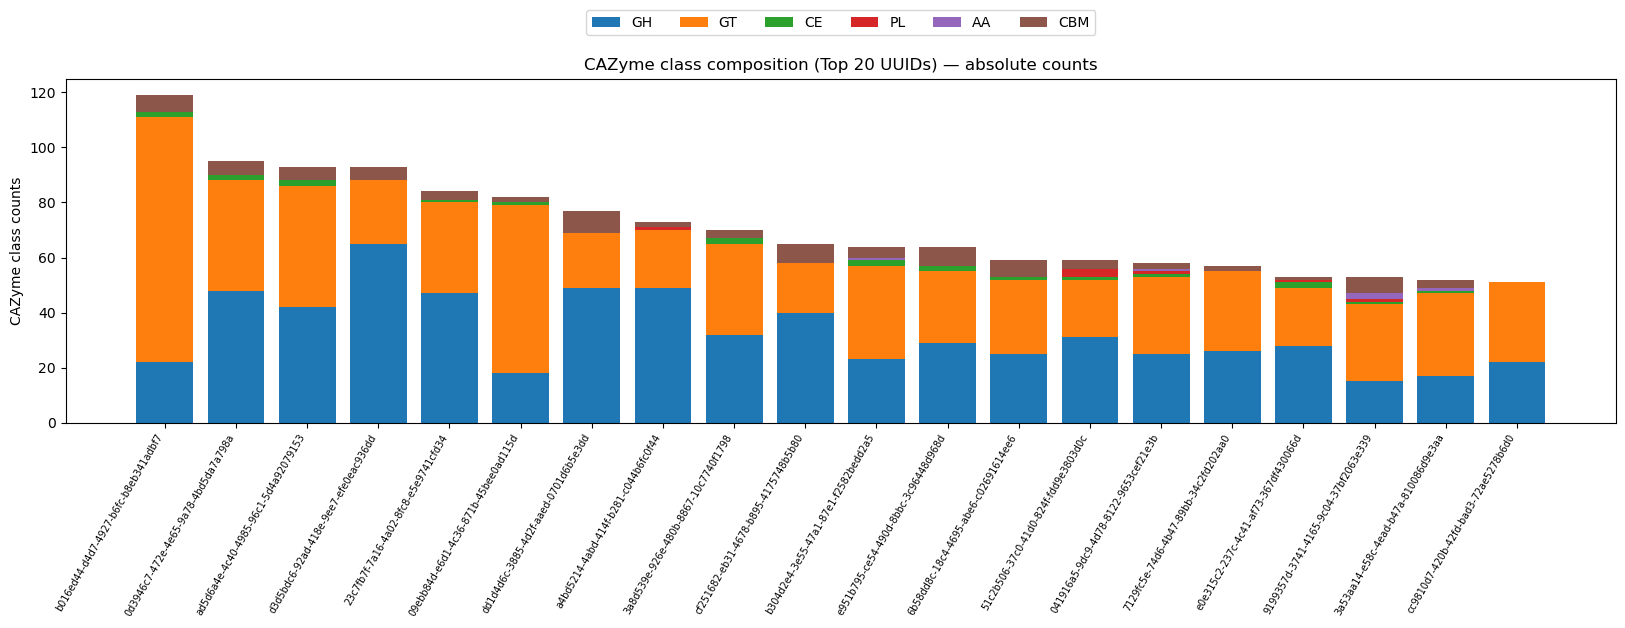

Saved: figures/cazy_class_top20_uuid_counts.pdf
Saved: figures/cazy_class_top20_uuid_counts.svg


,cazy_total
b016ed44-d4d7-4927-b6fc-b8eb341adbf7,119.0
0d3946c7-472e-4e65-9a78-4bd5da7a798a,95.0
ad5d6a4e-4c40-4985-96c1-5d4a92079153,93.0
d3d5bdc6-92ad-418e-9ee7-efe0eac936dd,93.0
23c7fb7f-7a16-4a02-8fc8-e5e9741cfd34,84.0
09ebb84d-e6d1-4c36-871b-45bee0ad115d,82.0
dd1d4d6c-3885-4d2f-aaed-0701d6b5e3dd,77.0
a4bd5214-4abd-414f-b281-c044b6fc0f44,73.0
3a8d539e-926e-480b-8867-10c7740f1798,70.0
cf251682-eb31-4678-b895-4175748b5b80,65.0


In [19]:
# =========================
# CAZyme class composition (use UUID sample IDs)
# Input: data/07_Functional_analysis/data/caz_annot_ft_bacteria_95.qza
# Output:
#   figures/cazy_class_topN_uuid_prop_annot.pdf/svg
#   figures/cazy_class_topN_uuid_counts.pdf/svg
# =========================

from pathlib import Path
import subprocess
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline

# ---------- config ----------
QZA = Path("data/07_Functional_analysis/data/caz_annot_ft_bacteria_95.qza")
EXPORT_DIR = Path("exported/caz_ft")
TSV = EXPORT_DIR / "feature-table.tsv"
OUT_DIR = Path("figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

N = 20  # Top N UUIDs

# ---------- export qza -> biom -> tsv ----------
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

subprocess.run([
    "qiime", "tools", "export",
    "--input-path", str(QZA),
    "--output-path", str(EXPORT_DIR)
], check=True)

subprocess.run([
    "biom", "convert",
    "-i", str(EXPORT_DIR / "feature-table.biom"),
    "-o", str(TSV),
    "--to-tsv"
], check=True)

# ---------- helpers ----------
def cazy_class(feature_id: str) -> str:
    m = re.match(r"^(GH|GT|CE|PL|AA|CBM)\d+", str(feature_id).strip(), flags=re.I)
    return m.group(1).upper() if m else "Other"

def read_biom_tsv(tsv_path: Path) -> pd.DataFrame:
    """
    biom convert 输出：
      line1: # Constructed from biom file
      line2: #OTU ID <sample1> <sample2> ...
    关键：只能跳过第一行，不能 comment="#"
    """
    df = pd.read_csv(tsv_path, sep="\t", skiprows=1)  # ✅ 正确：保留第2行表头
    # 第一列名一般是 '#OTU ID'（有的版本可能是 'OTU ID'）
    first_col = df.columns[0]
    df = df.set_index(first_col)
    return df

def stacked_bar(plot_df, title, ylabel, totals=None, out_prefix="plot", is_prop=False):
    order = [c for c in ["GH","GT","CE","PL","AA","CBM","Other"] if c in plot_df.columns]
    x = np.arange(plot_df.shape[0])

    fig, ax = plt.subplots(figsize=(20, 8))  # 更高更宽
    bottom = np.zeros(plot_df.shape[0])

    for cls in order:
        vals = plot_df[cls].values
        ax.bar(x, vals, bottom=bottom, label=cls)
        bottom += vals

    # --- totals annotation ---
    if totals is not None:
        if is_prop:
            # 比例图每根柱子顶端都接近 1，统一放到 1.03 避免挤在 legend/title 上
            y_text = 1.03
            for i, uid in enumerate(plot_df.index):
                ax.text(i, y_text, f"{int(totals.loc[uid])}",
                        ha="center", va="bottom", fontsize=8, rotation=0)
        else:
            # 绝对计数图就按柱子顶端+一点点
            ypad = 0.01 * (bottom.max() if bottom.max() > 0 else 1)
            for i, uid in enumerate(plot_df.index):
                ax.text(i, bottom[i] + ypad, f"{int(totals.loc[uid])}",
                        ha="center", va="bottom", fontsize=8, rotation=0)

    ax.set_xticks(x)
    ax.set_xticklabels(plot_df.index, rotation=60, ha="right", fontsize=7)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # legend 往上挪，留足顶部空间
    ax.legend(ncols=7, bbox_to_anchor=(0.5, 1.22), loc="upper center")

    # 留边距：底部给长 UUID，顶部给 legend+标注
    if is_prop:
        ax.set_ylim(0, 1.18)
    fig.subplots_adjust(bottom=0.35, top=0.78)

    pdf = OUT_DIR / f"{out_prefix}.pdf"
    svg = OUT_DIR / f"{out_prefix}.svg"
    fig.savefig(pdf, dpi=300)
    fig.savefig(svg)
    plt.show()
    print("Saved:", pdf)
    print("Saved:", svg)

# ---------- read matrix (features x UUIDs) ----------
df = read_biom_tsv(TSV)

# 数值矩阵：features x UUIDs
mat = df.apply(pd.to_numeric, errors="coerce").fillna(0)

print("Matrix shape (features x UUIDs):", mat.shape)
print("Example UUID columns:", list(mat.columns[:5]))

# ---------- sum into CAZyme classes ----------
classes = pd.Series(mat.index, index=mat.index).map(cazy_class)
class_sum = mat.groupby(classes).sum()  # class x UUID

# keep standard order
order = [c for c in ["GH","GT","CE","PL","AA","CBM","Other"] if c in class_sum.index]
class_sum = class_sum.loc[order]

totals_all = class_sum.sum(axis=0)

# ---------- top N UUIDs ----------
top_uuids = totals_all.sort_values(ascending=False).head(N).index
top_totals = totals_all.loc[top_uuids]

top_counts = class_sum[top_uuids].T  # UUID x class (counts)
top_prop = (class_sum[top_uuids] / top_totals.replace(0, np.nan)).T.fillna(0)  # UUID x class (prop)

# ---------- plot ----------
stacked_bar(
    plot_df=top_prop,
    title=f"CAZyme class composition (Top {N} UUIDs) — totals annotated",
    ylabel="Proportion of CAZyme classes",
    totals=top_totals,
    out_prefix=f"cazy_class_top{N}_uuid_prop_annot",
    is_prop=True
)

stacked_bar(
    plot_df=top_counts,
    title=f"CAZyme class composition (Top {N} UUIDs) — absolute counts",
    ylabel="CAZyme class counts",
    totals=None,
    out_prefix=f"cazy_class_top{N}_uuid_counts"
)

# ---------- top list ----------
top_list = top_totals.sort_values(ascending=False).to_frame("cazy_total")
display(top_list)


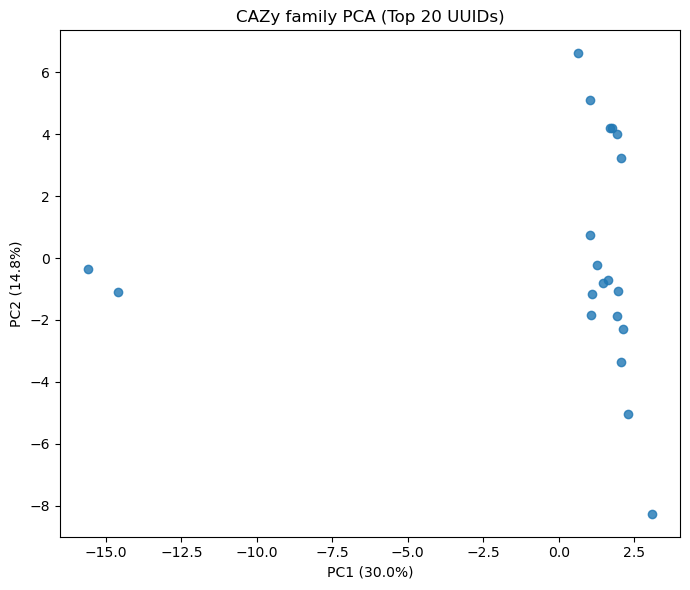

Saved: figures/cazy_pca_topN_uuid.png


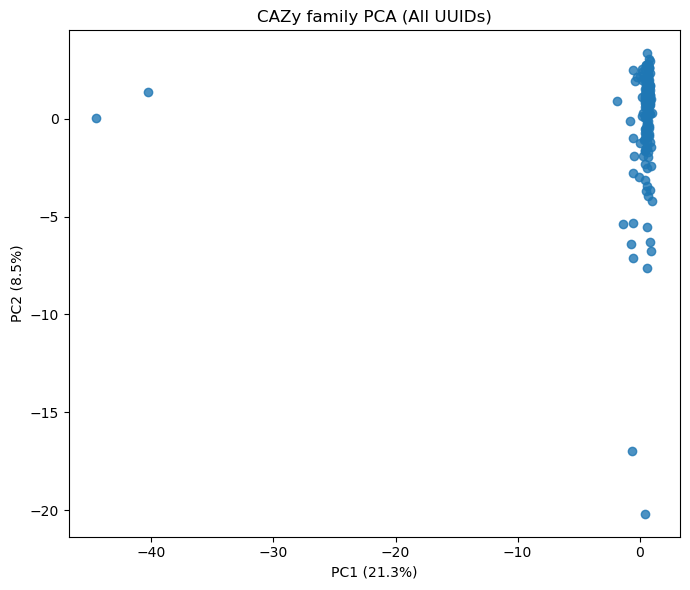

Saved: figures/cazy_pca_all_uuid.png


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 你现在已经有：
# mat: features (CAZy family) x UUIDs 的 count 矩阵
# top_uuids: 你上一张图选出来的 Top N UUIDs（如果没有，就用下面两行生成）
# totals_all = class_sum.sum(axis=0)
# top_uuids = totals_all.sort_values(ascending=False).head(N).index

OUT_DIR = Path("figures"); OUT_DIR.mkdir(exist_ok=True, parents=True)

def pca_2d(X: np.ndarray):
    """简单 PCA：返回 (scores2d, explained_variance_ratio[2])"""
    # center
    Xc = X - X.mean(axis=0, keepdims=True)
    # SVD
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    scores = U[:, :2] * S[:2]
    # explained variance ratio
    var = (S**2) / (X.shape[0]-1)
    evr = var / var.sum()
    return scores, evr[:2]

def make_pca_plot(mat_features_x_samples: pd.DataFrame, title: str, outpath: Path):
    # samples x features
    X = mat_features_x_samples.T.copy()

    # log transform (reduce skew)
    X = np.log1p(X)

    # z-score per feature
    X = (X - X.mean(axis=0)) / X.std(axis=0).replace(0, 1)

    scores, evr2 = pca_2d(X.values)

    plt.figure(figsize=(7, 6))
    plt.scatter(scores[:, 0], scores[:, 1], alpha=0.8)
    plt.xlabel(f"PC1 ({evr2[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({evr2[1]*100:.1f}%)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    print("Saved:", outpath)

# 1) TopN PCA
make_pca_plot(
    mat[top_uuids],  # features x top samples
    title=f"CAZy family PCA (Top {len(top_uuids)} UUIDs)",
    outpath=OUT_DIR / "cazy_pca_topN_uuid.png"
)

# 2) All samples PCA（可选：如果点太多不好看就注释掉）
make_pca_plot(
    mat,
    title="CAZy family PCA (All UUIDs)",
    outpath=OUT_DIR / "cazy_pca_all_uuid.png"
)


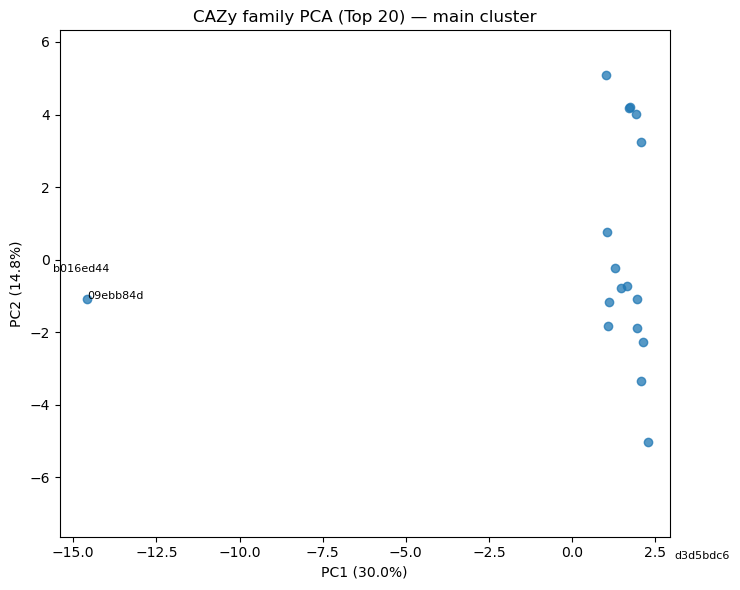

Saved: figures/cazy_pca_topN_uuid_maincluster.png


/tmp/ipykernel_3746/1312950267.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


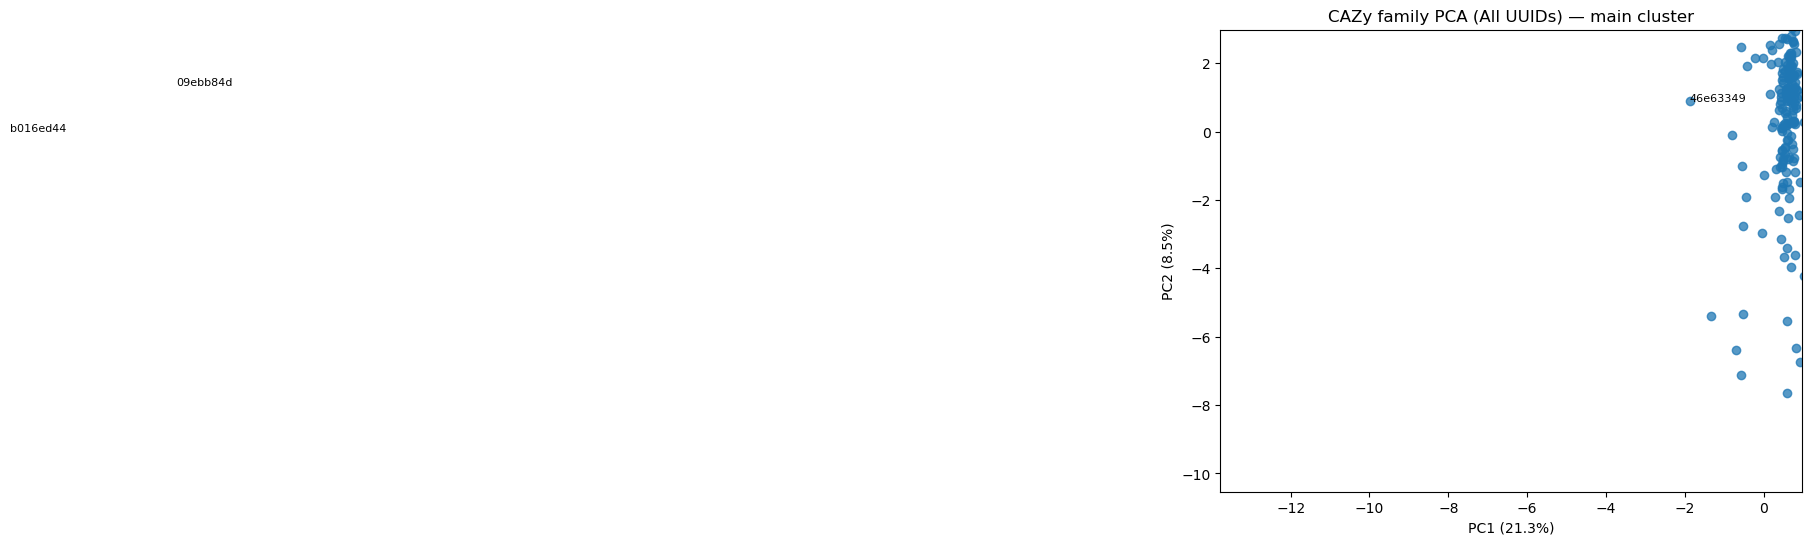

Saved: figures/cazy_pca_all_uuid_maincluster.png


In [21]:
import numpy as np
import matplotlib.pyplot as plt

def pca_2d(X: np.ndarray):
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    scores = U[:, :2] * S[:2]
    var = (S**2) / (X.shape[0]-1)
    evr = var / var.sum()
    return scores, evr[:2]

def pca_plot_with_outliers(mat_fxS, title, outpath, label_mode="prefix8", clip_quantile=0.99):
    # samples x features
    X = np.log1p(mat_fxS.T)
    X = (X - X.mean(axis=0)) / X.std(axis=0).replace(0, 1)

    scores, evr2 = pca_2d(X.values)
    ids = X.index.to_list()

    pc1 = scores[:,0]
    pc2 = scores[:,1]

    # 找离群点：按 PC1 绝对值最大的一小撮
    k = max(3, int(0.02 * len(ids)))  # 至少标3个，或前2%
    out_idx = np.argsort(np.abs(pc1))[-k:]

    # 主体簇裁剪显示范围（避免被离群点拉爆）
    lo1, hi1 = np.quantile(pc1, [1-clip_quantile, clip_quantile])
    lo2, hi2 = np.quantile(pc2, [1-clip_quantile, clip_quantile])

    plt.figure(figsize=(7.5, 6))
    plt.scatter(pc1, pc2, alpha=0.75)

    # 标注离群点
    for i in out_idx:
        lab = ids[i]
        if label_mode == "prefix8":
            lab = lab[:8]
        plt.text(pc1[i], pc2[i], lab, fontsize=8)

    plt.xlim(lo1, hi1)
    plt.ylim(lo2, hi2)
    plt.xlabel(f"PC1 ({evr2[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({evr2[1]*100:.1f}%)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    print("Saved:", outpath)

# 用法（把 mat/top_uuids 换成你当前变量）
pca_plot_with_outliers(
    mat[top_uuids], 
    title=f"CAZy family PCA (Top {len(top_uuids)}) — main cluster",
    outpath=OUT_DIR / "cazy_pca_topN_uuid_maincluster.png"
)

pca_plot_with_outliers(
    mat, 
    title="CAZy family PCA (All UUIDs) — main cluster",
    outpath=OUT_DIR / "cazy_pca_all_uuid_maincluster.png"
)

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported data/07_Functional_analysis/data/caz_annot_ft_bacteria_95.qza as BIOMV210DirFmt to directory exported/caz_ft


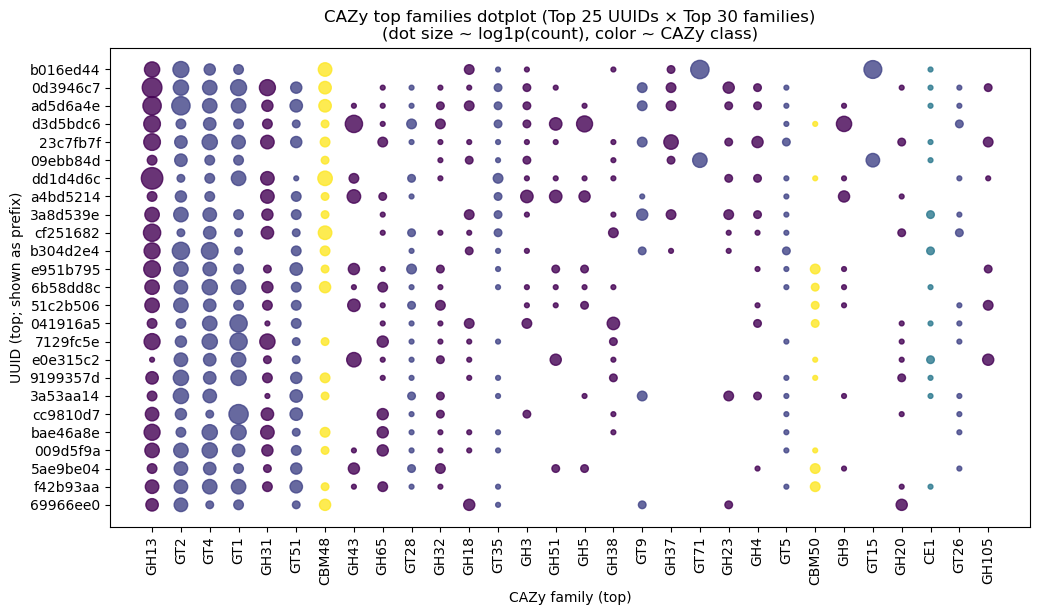

Saved: figures/cazy_topfamilies_dotplot.png


In [23]:
from pathlib import Path
import subprocess, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path("data/07_Functional_analysis/data")
OUT_DIR = Path("figures"); OUT_DIR.mkdir(parents=True, exist_ok=True)

CAZ_QZA = DATA_DIR / "caz_annot_ft_bacteria_95.qza"
CAZ_EXPORT = Path("exported/caz_ft"); CAZ_EXPORT.mkdir(parents=True, exist_ok=True)
CAZ_TSV = CAZ_EXPORT / "feature-table.tsv"

N_SAMPLES = 25   # 展示多少个UUID（按总CAZy counts排序）
N_FAMS = 30      # 展示多少个CAZy family（按总丰度排序）

def export_qza_to_tsv(qza: Path, export_dir: Path, tsv_path: Path):
    subprocess.run(["qiime","tools","export","--input-path",str(qza),"--output-path",str(export_dir)], check=True)
    subprocess.run(["biom","convert","-i",str(export_dir/"feature-table.biom"),"-o",str(tsv_path),"--to-tsv"], check=True)

def read_biom_tsv(tsv_path: Path) -> pd.DataFrame:
    # biom convert 输出：第1行注释，第2行才是真表头（#OTU ID + sample IDs）
    df = pd.read_csv(tsv_path, sep="\t", skiprows=1)
    df = df.set_index(df.columns[0])
    df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
    return df

def cazy_class(fam: str) -> str:
    m = re.match(r"^(GH|GT|CE|PL|AA|CBM)\d+", str(fam).strip(), flags=re.I)
    return m.group(1).upper() if m else "Other"

# --- load CAZ table ---
export_qza_to_tsv(CAZ_QZA, CAZ_EXPORT, CAZ_TSV)
mat = read_biom_tsv(CAZ_TSV)  # features (families) x UUIDs

# 选 Top UUID（按总CAZy counts）
sample_totals = mat.sum(axis=0).sort_values(ascending=False)
top_samples = sample_totals.head(N_SAMPLES).index

# 选 Top families（在这些样本中按总丰度）
fam_totals = mat[top_samples].sum(axis=1).sort_values(ascending=False)
top_fams = fam_totals.head(N_FAMS).index

sub = mat.loc[top_fams, top_samples]  # fam x sample
# sub: fam x sample (DataFrame)
# 可靠生成 long format，不依赖 stack 后的默认列名
long = (
    sub.stack()
      .reset_index(name="count")  # ✅ 直接把数值列命名为 count
)

# 前两列就是 family 和 uuid（用实际列名改名）
long.columns = ["family", "uuid", "count"]

# 现在肯定有 family 了
long["class"] = long["family"].map(cazy_class)
long["size"] = np.log1p(long["count"])
long = long[long["count"] > 0].copy()


# 类别编码（用默认 colormap，不手动指定具体颜色）
class_order = ["GH","GT","CE","PL","AA","CBM","Other"]
long["class"] = pd.Categorical(long["class"], categories=class_order, ordered=True)
long["class_code"] = long["class"].cat.codes

# 轴顺序：uuid按总量从高到低；family按总丰度从高到低
uuid_order = list(top_samples)
fam_order = list(top_fams)
uuid_to_y = {u:i for i,u in enumerate(uuid_order)}
fam_to_x = {f:i for i,f in enumerate(fam_order)}
long["x"] = long["family"].map(fam_to_x)
long["y"] = long["uuid"].map(uuid_to_y)

plt.figure(figsize=(max(10, N_FAMS*0.35), max(6, N_SAMPLES*0.25)))
plt.scatter(
    long["x"], long["y"],
    s=(long["size"]**2)*25,   # 放大一点
    c=long["class_code"],
    alpha=0.8
)
plt.xticks(range(len(fam_order)), fam_order, rotation=90)
plt.yticks(range(len(uuid_order)), [u[:8] for u in uuid_order])  # y轴显示UUID前8位更清爽（不影响追溯）
plt.gca().invert_yaxis()
plt.xlabel("CAZy family (top)")
plt.ylabel("UUID (top; shown as prefix)")
plt.title(f"CAZy top families dotplot (Top {N_SAMPLES} UUIDs × Top {N_FAMS} families)\n(dot size ~ log1p(count), color ~ CAZy class)")
plt.tight_layout()
out = OUT_DIR / "cazy_topfamilies_dotplot.png"
plt.savefig(out, dpi=300)
plt.show()
print("Saved:", out)

# 同时导出你这张图用到的 Top UUID / Top family 列表，方便写稿
pd.DataFrame({"uuid": uuid_order, "total_cazy": sample_totals.loc[uuid_order].values}).to_csv(
    OUT_DIR/"cazy_top_uuid_list.tsv", sep="\t", index=False
)
pd.DataFrame({"family": fam_order, "total_in_top_uuid": fam_totals.loc[fam_order].values,
              "class": [cazy_class(f) for f in fam_order]}).to_csv(
    OUT_DIR/"cazy_top_family_list.tsv", sep="\t", index=False
)


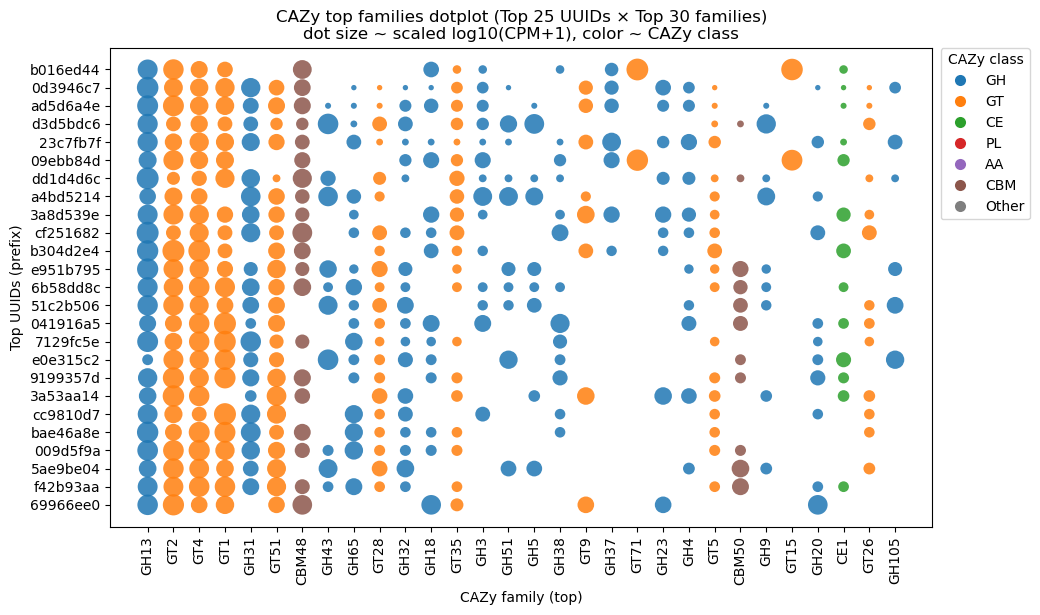

Saved: figures/cazy_topfamilies_dotplot_rel_discrete.png


In [32]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# ---------------------------
# params (按需改)
# ---------------------------
N_SAMPLES = 25   # Top UUIDs
N_FAMS = 30      # Top families
OUT = Path("figures/cazy_topfamilies_dotplot_rel_discrete.png")

def cazy_class(fam: str) -> str:
    m = re.match(r"^(GH|GT|CE|PL|AA|CBM)\d+", str(fam).strip(), flags=re.I)
    return m.group(1).upper() if m else "Other"

# ---------------------------
# choose top samples/families
# ---------------------------
sample_totals = mat.sum(axis=0).sort_values(ascending=False)
top_samples = sample_totals.head(N_SAMPLES).index

fam_totals = mat[top_samples].sum(axis=1).sort_values(ascending=False)
top_fams = fam_totals.head(N_FAMS).index

sub = mat.loc[top_fams, top_samples]  # fam x uuid (counts)

# ---------------------------
# convert to relative abundance within each UUID
# ---------------------------
sub_rel = sub.div(sub.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)  # fam x uuid

# long table: family, uuid, rel
long = sub_rel.stack().reset_index(name="rel")
long.columns = ["family", "uuid", "rel"]
long = long[long["rel"] > 0].copy()

# ---------------------------
# size and color (discrete by class)
# ---------------------------
long["class"] = long["family"].map(cazy_class)

class_order = ["GH","GT","CE","PL","AA","CBM","Other"]
class_to_idx = {c:i for i,c in enumerate(class_order)}
long["class_idx"] = long["class"].map(class_to_idx).fillna(class_to_idx["Other"]).astype(int)

# 点大小：用 CPM-like + log，视觉更稳定
# rel ∈ (0,1)，乘 1e6 类似 CPM，再 log10
long["size"] = np.log10(long["rel"] * 1e6 + 1)

# 轴顺序（和你之前一致）：UUID 按总量从高到低；family 按总丰度从高到低
uuid_order = list(top_samples)
fam_order = list(top_fams)
uuid_to_y = {u:i for i,u in enumerate(uuid_order)}
fam_to_x = {f:i for i,f in enumerate(fam_order)}
long["x"] = long["family"].map(fam_to_x)
long["y"] = long["uuid"].map(uuid_to_y)

# ---------------------------
# plot (UPDATED: size scaling + fixed class colors)
# ---------------------------
from matplotlib.lines import Line2D

fig_w = max(10, N_FAMS * 0.35)
fig_h = max(6, N_SAMPLES * 0.25)
plt.figure(figsize=(fig_w, fig_h))

# 颜色映射：和 stacked bar 一致（matplotlib tab10 的前6个）
tab10 = plt.get_cmap("tab10")
class_colors = {
    "GH": tab10(0),   # blue
    "GT": tab10(1),   # orange
    "CE": tab10(2),   # green
    "PL": tab10(3),   # red
    "AA": tab10(4),   # purple
    "CBM": tab10(5),  # brown
    "Other": tab10(7)
}
point_colors = long["class"].apply(lambda x: class_colors.get(x, class_colors["Other"])).tolist()


# 大小：把 log10(CPM+1) 做分位拉伸到一个宽区间，保证差异可见
v = long["size"].values  # 你上面算的 log10(CPM+1)
v_lo, v_hi = np.quantile(v, [0.01, 0.99])
v_scaled = (v - v_lo) / (v_hi - v_lo + 1e-12)
v_scaled = np.clip(v_scaled, 0, 1)

s_min, s_max = 15, 250
sizes = s_min + v_scaled * (s_max - s_min)

plt.scatter(
    long["x"], long["y"],
    s=sizes,
    c=point_colors,
    alpha=0.85,
    edgecolors="none"
)

plt.xticks(range(len(fam_order)), fam_order, rotation=90)
plt.yticks(range(len(uuid_order)), [u[:8] for u in uuid_order])
plt.gca().invert_yaxis()
plt.xlabel("CAZy family (top)")
plt.ylabel("Top UUIDs (prefix)")
plt.title(
    f"CAZy top families dotplot (Top {N_SAMPLES} UUIDs × Top {N_FAMS} families)\n"
    f"dot size ~ scaled log10(CPM+1), color ~ CAZy class"
)

# 用 legend 做离散 class 图例（更像 PPT）
handles = [
    Line2D([0], [0], marker="o", linestyle="", label=cls,
           markerfacecolor=class_colors[cls], markeredgecolor="none", markersize=8)
    for cls in ["GH","GT","CE","PL","AA","CBM","Other"]
]
plt.legend(handles=handles, title="CAZy class", bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.savefig(OUT, dpi=300)
plt.show()
print("Saved:", OUT)


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported data/07_Functional_analysis/data/cog_annot_ft_bacteria_95.qza as BIOMV210DirFmt to directory exported/cog_ft
COG matrix shape (features x UUIDs): (24, 170)
Example features: ['S', 'J', 'E', 'G', 'L', 'K', 'P', 'M', 'F', 'C']
Example UUIDs: ['009d5f9a-be92-4328-b5ad-68d282a94e3b', '0174159a-d8ba-4d10-995d-c9dddd2a0b48', '01b54364-1bbb-43e7-9366-a931641ff6cd', '033e4bc6-2e06-4d36-a408-30aae536885c', '03727db6-e5bc-48a7-8dd0-01ef817cde25']


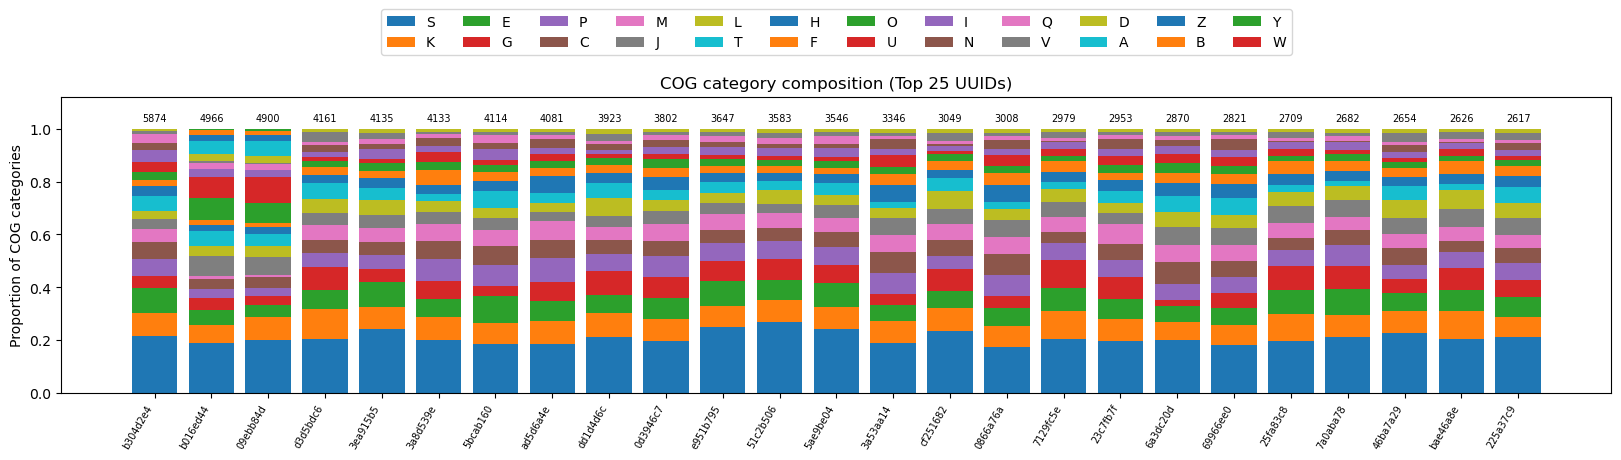

Saved: figures/cog_category_stackedbar_topUUID_annot_inframe.png


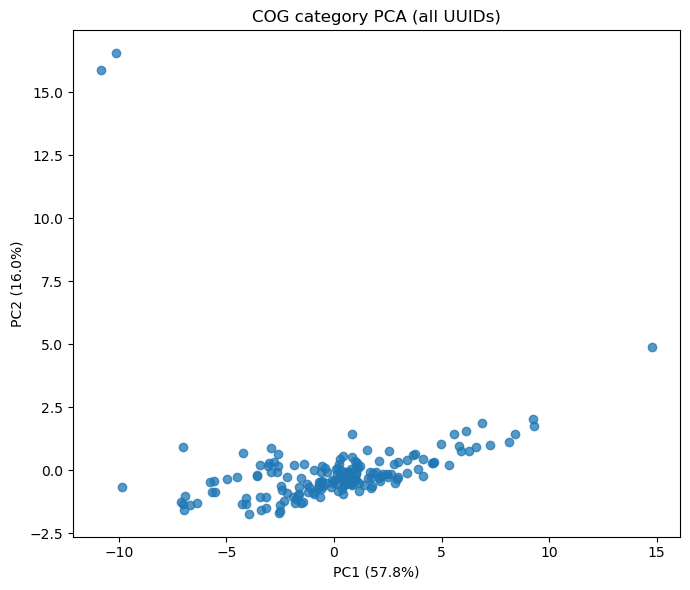

Saved: figures/cog_category_pca.png


In [38]:
from pathlib import Path
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------
# paths
# -------------------
DATA_DIR = Path("data/07_Functional_analysis/data")
COG_QZA = DATA_DIR / "cog_annot_ft_bacteria_95.qza"

OUT_DIR = Path("figures"); OUT_DIR.mkdir(parents=True, exist_ok=True)
EXPORT_DIR = Path("exported/cog_ft"); EXPORT_DIR.mkdir(parents=True, exist_ok=True)
TSV = EXPORT_DIR / "feature-table.tsv"

# -------------------
# export qza -> tsv
# -------------------
subprocess.run(
    ["qiime", "tools", "export", "--input-path", str(COG_QZA), "--output-path", str(EXPORT_DIR)],
    check=True
)
subprocess.run(
    ["biom", "convert", "-i", str(EXPORT_DIR / "feature-table.biom"), "-o", str(TSV), "--to-tsv"],
    check=True
)

def read_biom_tsv(tsv_path: Path) -> pd.DataFrame:
    """
    biom convert 输出：
      line1: # Constructed from biom file
      line2: #OTU ID <sample1> <sample2> ...
    所以：跳过第1行，用第2行作为表头
    """
    df = pd.read_csv(tsv_path, sep="\t", skiprows=1)
    df = df.set_index(df.columns[0])
    df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
    return df  # features x UUIDs

def pca_2d(X: np.ndarray):
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    scores = U[:, :2] * S[:2]
    var = (S**2) / (X.shape[0]-1)
    evr = var / var.sum()
    return scores, evr[:2]

# -------------------
# load table
# -------------------
cog_mat = read_biom_tsv(TSV)
print("COG matrix shape (features x UUIDs):", cog_mat.shape)
print("Example features:", list(cog_mat.index[:10]))
print("Example UUIDs:", list(cog_mat.columns[:5]))

feat = cog_mat.index.astype(str)
is_letter_cat = feat.map(lambda x: len(x) == 1 and x.isalpha()).all()

# -------------------
# CASE A: single-letter categories
# -------------------
if is_letter_cat:
    cat_sum = cog_mat.groupby(feat).sum()     # category x UUID
    totals = cat_sum.sum(axis=0)              # total per UUID

    # Top UUIDs
    N_UUID = 25
    top_uuid = totals.sort_values(ascending=False).head(N_UUID).index

    # Proportions for stacked bar
    prop = (cat_sum[top_uuid] / totals.loc[top_uuid].replace(0, np.nan)).T.fillna(0)  # UUID x category
    cat_order = prop.sum(axis=0).sort_values(ascending=False).index
    prop = prop[cat_order]

    # ---- plot stacked bar ----
    fig, ax = plt.subplots(figsize=(20, 8))
    x = np.arange(prop.shape[0])
    bottom = np.zeros(prop.shape[0])

    for c in prop.columns:
        vals = prop[c].values
        ax.bar(x, vals, bottom=bottom, label=c)
        bottom += vals

    # 数字放框内：给顶部留空，然后用数据坐标 y=1.02
    ax.set_ylim(0, 1.12)  # ✅ 关键：框内留空间
    for i, u in enumerate(prop.index):
        ax.text(
            i, 1.02, f"{int(totals.loc[u])}",
            ha="center", va="bottom", fontsize=7,
            clip_on=True
        )

    ax.set_xticks(x)
    ax.set_xticklabels([u[:8] for u in prop.index], rotation=60, ha="right", fontsize=7)
    ax.set_ylabel("Proportion of COG categories")
    ax.set_title(f"COG category composition (Top {N_UUID} UUIDs)")

    # legend 放上面，留足空间
    fig.subplots_adjust(bottom=0.35, top=0.72)
    ax.legend(ncols=12, bbox_to_anchor=(0.5, 1.32), loc="upper center")

    out1 = OUT_DIR / "cog_category_stackedbar_topUUID_annot_inframe.png"
    fig.savefig(out1, dpi=300)
    plt.show()
    print("Saved:", out1)

    # ---- PCA on categories (all UUIDs) ----
    X = np.log1p(cat_sum.T)
    X = (X - X.mean(axis=0)) / X.std(axis=0).replace(0, 1)
    scores, evr2 = pca_2d(X.values)

    plt.figure(figsize=(7, 6))
    plt.scatter(scores[:, 0], scores[:, 1], alpha=0.75)
    plt.xlabel(f"PC1 ({evr2[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({evr2[1]*100:.1f}%)")
    plt.title("COG category PCA (all UUIDs)")
    plt.tight_layout()

    out2 = OUT_DIR / "cog_category_pca.png"
    plt.savefig(out2, dpi=300)
    plt.show()
    print("Saved:", out2)

# -------------------
# CASE B: not single-letter categories
# -------------------
else:
    print("⚠️ features 不是单字母 COG 类别（J/K/L...）。当前表无法直接做‘类别堆叠图’。")
    print("   我先输出 PCA（按 feature 本身），如果要按类别聚合，需要 COG_ID->类别 的映射表。")

    X = np.log1p(cog_mat.T)
    X = (X - X.mean(axis=0)) / X.std(axis=0).replace(0, 1)
    scores, evr2 = pca_2d(X.values)

    plt.figure(figsize=(7, 6))
    plt.scatter(scores[:, 0], scores[:, 1], alpha=0.75)
    plt.xlabel(f"PC1 ({evr2[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({evr2[1]*100:.1f}%)")
    plt.title("COG feature PCA (all UUIDs)")
    plt.tight_layout()

    outp = OUT_DIR / "cog_feature_pca.png"
    plt.savefig(outp, dpi=300)
    plt.show()
    print("Saved:", outp)


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported data/07_Functional_analysis/data/amr_ft_bacteria_95.qza as BIOMV210DirFmt to directory exported/amr_ft


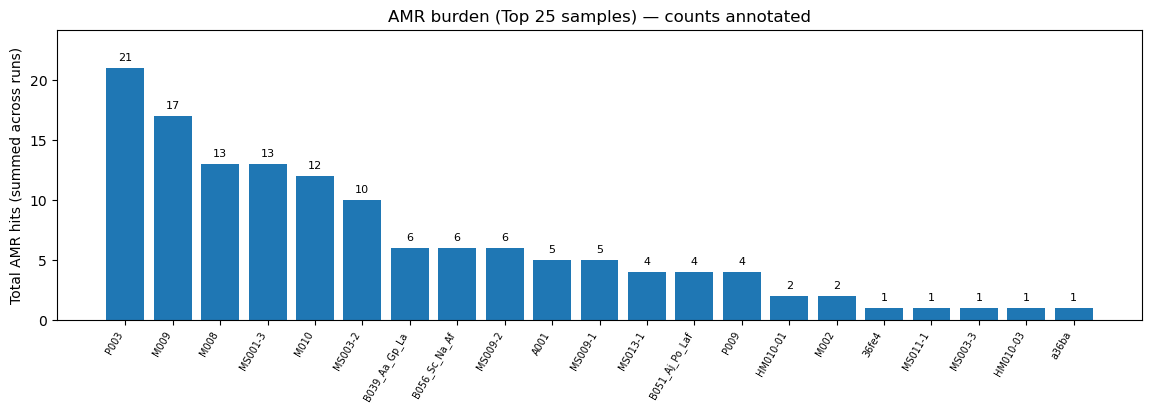

Saved: figures/amr_total_counts_topSamples.png
Saved: figures/amr_total_topSamples.tsv


In [53]:
from pathlib import Path
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# AMR total burden by SAMPLE (merge runs)
# Input: FeatureTable[Frequency] amr_ft_bacteria_95.qza
# Output:
#   figures/amr_total_counts_topSamples.png
#   figures/amr_total_topSamples.tsv
# =========================

DATA_DIR = Path("data/07_Functional_analysis/data")
AMR_FT_QZA = DATA_DIR / "amr_ft_bacteria_95.qza"

OUT_DIR = Path("figures"); OUT_DIR.mkdir(parents=True, exist_ok=True)
EXP_FT  = Path("exported/amr_ft");  EXP_FT.mkdir(parents=True, exist_ok=True)
FT_TSV  = EXP_FT / "feature-table.tsv"

def read_biom_tsv(tsv_path: Path) -> pd.DataFrame:
    # biom convert 输出：第1行注释，第2行表头（#OTU ID + sample IDs）
    df = pd.read_csv(tsv_path, sep="\t", skiprows=1)
    df = df.set_index(df.columns[0])
    df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
    return df  # features x columns(run IDs)

def extract_sample(col: str) -> str:
    """
    Column example:
      PB_MS001-3/01486816-...
      IL_A001/71779113-...
    We want sample name without platform prefix and without /uuid:
      MS001-3, A001, B056_Sc_Na_Af, ...
    """
    left = str(col).split("/", 1)[0]
    left = left.replace("PB_", "", 1).replace("IL_", "", 1)
    return left

# --------- export qza -> tsv ----------
subprocess.run(
    ["qiime", "tools", "export", "--input-path", str(AMR_FT_QZA), "--output-path", str(EXP_FT)],
    check=True
)
subprocess.run(
    ["biom", "convert", "-i", str(EXP_FT / "feature-table.biom"), "-o", str(FT_TSV), "--to-tsv"],
    check=True
)

# --------- load ----------
amr_mat = read_biom_tsv(FT_TSV)

# --------- total per run ----------
totals_run = amr_mat.sum(axis=0)  # index = run IDs (columns)

df = pd.DataFrame({
    "run": totals_run.index.astype(str),
    "amr_total": totals_run.values
})
df["sample"] = df["run"].map(extract_sample)

# --------- merge runs -> sample ----------
by_sample = df.groupby("sample", as_index=True)["amr_total"].sum().sort_values(ascending=False)

# --------- plot Top N samples ----------
N_SAMPLES = 25
top_s = by_sample.head(N_SAMPLES)

fig, ax = plt.subplots(figsize=(14, 5))
x = np.arange(len(top_s))
ax.bar(x, top_s.values)

ymax = top_s.max() if top_s.max() > 0 else 1
ax.set_ylim(0, ymax * 1.15)

for i, s in enumerate(top_s.index):
    ax.text(i, top_s.loc[s] + ymax * 0.02, f"{int(top_s.loc[s])}",
            ha="center", va="bottom", fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(top_s.index.tolist(), rotation=60, ha="right", fontsize=7)
ax.set_ylabel("Total AMR hits (summed across runs)")
ax.set_title(f"AMR burden (Top {N_SAMPLES} samples) — counts annotated")
fig.subplots_adjust(bottom=0.30)

out_fig = OUT_DIR / "amr_total_counts_topSamples.png"
fig.savefig(out_fig, dpi=300)
plt.show()
print("Saved:", out_fig)

# --------- save table ----------
out_tsv = OUT_DIR / "amr_total_topSamples.tsv"
top_s.to_frame("amr_total_sum_runs").to_csv(out_tsv, sep="\t")
print("Saved:", out_tsv)


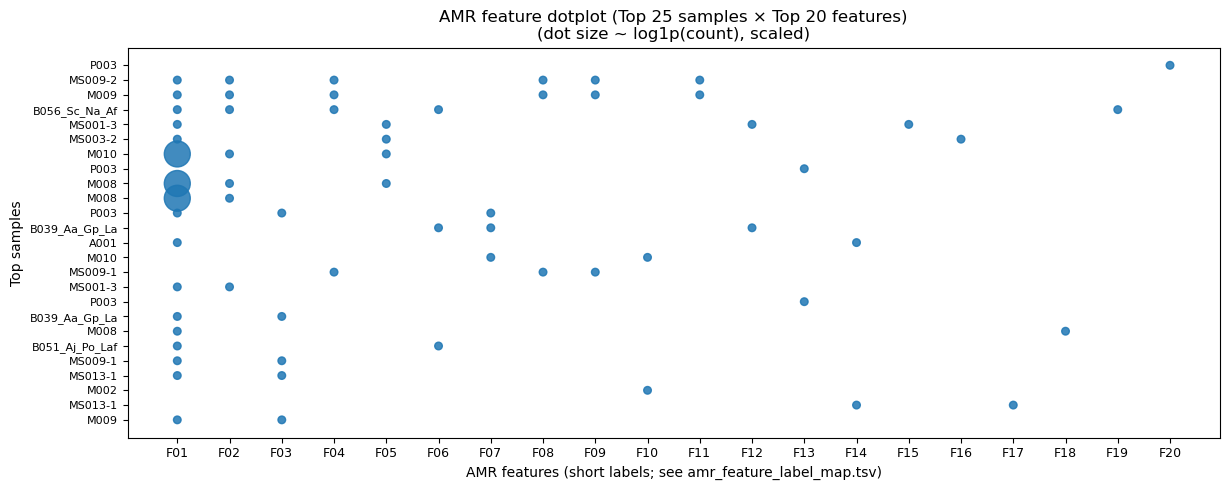

Saved: figures/amr_feature_dotplot_topSamples_clean.png
Also wrote: figures/amr_feature_label_map.tsv


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# AMR dotplot (Top samples × Top features)
# - y axis shows parsed sample name (strip PB_/IL_ and trailing /UUID)
# - x axis uses short feature labels F01..Fxx + mapping table
# =========================

OUT_DIR = Path("figures")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# --------- OPTIONAL: if you don't already have amr_mat ----------
# (uncomment if needed)
# def read_biom_tsv(tsv_path: Path) -> pd.DataFrame:
#     df = pd.read_csv(tsv_path, sep="\t", skiprows=1)
#     df = df.set_index(df.columns[0])
#     df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
#     return df
# amr_mat = read_biom_tsv(Path("exported/amr_ft/feature-table.tsv"))

# --------- params ----------
N_SAMPLES = 25   # top columns
N_FEAT = 20      # top features

def extract_sample(col: str) -> str:
    """PB_MS001-3/uuid -> MS001-3 ; IL_xxx/uuid -> xxx"""
    left = str(col).split("/", 1)[0]
    left = left.replace("PB_", "", 1).replace("IL_", "", 1)
    return left

# --------- pick top samples & features ----------
sample_totals = amr_mat.sum(axis=0).sort_values(ascending=False)
top_cols = sample_totals.head(N_SAMPLES).index  # these are your column IDs like PB_xxx/uuid

feat_totals = amr_mat[top_cols].sum(axis=1).sort_values(ascending=False)
top_feat = feat_totals.head(N_FEAT).index

sub = amr_mat.loc[top_feat, top_cols]  # feature x col

# --------- long format ----------
long = sub.stack().reset_index(name="count")
long.columns = ["feature", "col", "count"]
long = long[long["count"] > 0].copy()

# --------- x labels: short feature labels ----------
feat_order = list(top_feat)
feat_label = {f: f"F{i+1:02d}" for i, f in enumerate(feat_order)}
long["feat_short"] = long["feature"].map(feat_label)

# export label map for speaker notes / supplement
label_map = pd.DataFrame({
    "feat_short": [feat_label[f] for f in feat_order],
    "feature": feat_order,
    "total_in_top_samples": feat_totals.loc[feat_order].values
})
label_map.to_csv(OUT_DIR / "amr_feature_label_map.tsv", sep="\t", index=False)

# --------- point sizes (make differences visible) ----------
v = np.log1p(long["count"].values)
v_lo, v_hi = np.quantile(v, [0.01, 0.99])
v_scaled = np.clip((v - v_lo) / (v_hi - v_lo + 1e-12), 0, 1)
s_min, s_max = 30, 350
sizes = s_min + v_scaled * (s_max - s_min)

# --------- axes mapping ----------
col_order = list(top_cols)  # keep the AMR-total ranking order
y_labels = [extract_sample(c) for c in col_order]

short_order = [feat_label[f] for f in feat_order]

col_to_y = {c:i for i, c in enumerate(col_order)}
short_to_x = {s:i for i, s in enumerate(short_order)}

long["x"] = long["feat_short"].map(short_to_x)
long["y"] = long["col"].map(col_to_y)

# --------- plot ----------
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(long["x"], long["y"], s=sizes, alpha=0.85)

ax.set_xticks(range(len(short_order)))
ax.set_xticklabels(short_order, rotation=0, fontsize=9)

ax.set_yticks(range(len(col_order)))
ax.set_yticklabels(y_labels, fontsize=8)
ax.invert_yaxis()

ax.set_xlabel("AMR features (short labels; see amr_feature_label_map.tsv)")
ax.set_ylabel("Top samples")
ax.set_title(f"AMR feature dotplot (Top {N_SAMPLES} samples × Top {N_FEAT} features)\n(dot size ~ log1p(count), scaled)")

# margins
fig.subplots_adjust(left=0.20, bottom=0.20, top=0.85, right=0.98)

out = OUT_DIR / "amr_feature_dotplot_topSamples_clean.png"
fig.savefig(out, dpi=300)
plt.show()

print("Saved:", out)
print("Also wrote:", OUT_DIR / "amr_feature_label_map.tsv")


In [48]:
import pandas as pd

meta = pd.read_csv("data/processed/metadata/Metadata_Extended.tsv", sep="\t")

cols = pd.Index(amr_mat.columns.astype(str))   # 或换成你别的表 mat.columns

def extract_sample(col: str) -> str:
    left = col.split("/", 1)[0]     # PB_MS001-3
    left = left.replace("PB_", "", 1).replace("IL_", "", 1)  # MS001-3
    return left

def extract_uuid(col: str) -> str:
    parts = col.split("/", 1)
    return parts[1] if len(parts) == 2 else ""

parsed = pd.DataFrame({
    "col": cols,
    "sample": [extract_sample(c) for c in cols],
    "uuid":   [extract_uuid(c) for c in cols],
})

# 匹配率（现在应该不为0了）
rate = parsed["sample"].isin(meta["sample"].astype(str)).mean()
print("match parsed sample rate:", rate)

# 看看几个例子对不对
print(parsed.head(10))
print(meta["sample"].dropna().astype(str).unique()[:10])


match parsed sample rate: 1.0
                                                 col         sample  \
0      PB_36fe4/c88cd039-0ff8-40c0-bd20-0af1fd0a313c          36fe4   
1    PB_MS003-2/54ec05a3-8dea-417a-bb80-07575b39089e        MS003-2   
2    PB_MS001-3/01486816-578c-46dd-aeee-18a440cb7586        MS001-3   
3       PB_M010/eb5f1c06-8305-43e2-a47b-b2e72f0e1297           M010   
4       PB_M010/b3bc2063-df79-41ad-9109-31a480319c58           M010   
5       PB_A001/cc9810d7-420b-42fd-bad3-72ae5278b6d0           A001   
6       PB_A001/c90e82df-057b-4e87-ae36-91aa43fca39b           A001   
7       PB_A001/fc7c1562-4194-480d-afc1-d2e3c0d649a4           A001   
8       PB_P009/49d002ac-ed76-4ad6-99c2-1692945a49c5           P009   
9  PB_B056_Sc_Na_Af/16290cc5-ae7b-4bb9-bf2e-459a1...  B056_Sc_Na_Af   

                                   uuid  
0  c88cd039-0ff8-40c0-bd20-0af1fd0a313c  
1  54ec05a3-8dea-417a-bb80-07575b39089e  
2  01486816-578c-46dd-aeee-18a440cb7586  
3  eb5f1c06-8305-43e

In [49]:
meta_s = meta.drop_duplicates("sample").set_index("sample")

parsed["fermented_food_type"] = parsed["sample"].map(meta_s["fermented_food_type"].to_dict())
parsed["category"] = parsed["sample"].map(meta_s["category"].to_dict())
parsed["samp_country"] = parsed["sample"].map(meta_s["samp_country"].to_dict())

display(parsed.head())


,col,sample,uuid,fermented_food_type,category,samp_country
0,PB_36fe4/c88cd039-0ff8-40c0-bd20-0af1fd0a313c,36fe4,c88cd039-0ff8-40c0-bd20-0af1fd0a313c,Kefir,fermented legumes,Slovenia
1,PB_MS003-2/54ec05a3-8dea-417a-bb80-07575b39089e,MS003-2,54ec05a3-8dea-417a-bb80-07575b39089e,Fermented_fish_sauce,fermented fish,Laos
2,PB_MS001-3/01486816-578c-46dd-aeee-18a440cb7586,MS001-3,01486816-578c-46dd-aeee-18a440cb7586,Fermented_fish_sauce,fermented fish,Laos
3,PB_M010/eb5f1c06-8305-43e2-a47b-b2e72f0e1297,M010,eb5f1c06-8305-43e2-a47b-b2e72f0e1297,Fermented_fish_(Pla_Som)_from_grass_carp,fermented fish,Thailand
4,PB_M010/b3bc2063-df79-41ad-9109-31a480319c58,M010,b3bc2063-df79-41ad-9109-31a480319c58,Fermented_fish_(Pla_Som)_from_grass_carp,fermented fish,Thailand


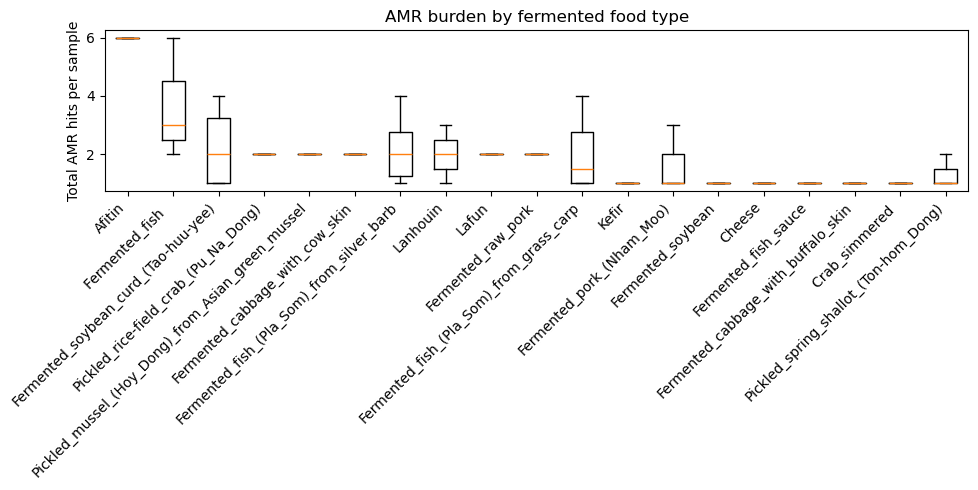

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# 每列总 AMR hits
amr_total_per_col = amr_mat.sum(axis=0)
df = parsed.set_index("col").join(amr_total_per_col.rename("amr_total")).dropna(subset=["fermented_food_type"])

order = df.groupby("fermented_food_type")["amr_total"].median().sort_values(ascending=False).index.tolist()
data = [df.loc[df["fermented_food_type"]==g, "amr_total"].values for g in order]

plt.figure(figsize=(10, 5))
plt.boxplot(data, labels=order, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total AMR hits per sample")
plt.title("AMR burden by fermented food type")
plt.tight_layout()
plt.show()


In [54]:
from pathlib import Path
import re
import pandas as pd

# ========= paths =========
META_PATH = Path("data/processed/metadata/Metadata_Extended.tsv")
ILL_DIR   = Path("data/Illumina_MAGs")
PB_DIR    = Path("data/PacBio_MAGs")

# ========= regex =========
UUID_RE = re.compile(r"[0-9a-fA-F]{8}-[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-[0-9a-fA-F]{12}")

FA_EXTS = {".fa", ".fna", ".fasta", ".faa"}

def first_fasta_header(fp: Path) -> str:
    """Read first header line starting with '>' (best-effort)."""
    try:
        with fp.open("r", errors="ignore") as f:
            for line in f:
                if line.startswith(">"):
                    return line[1:].strip()
    except Exception:
        return ""
    return ""

def find_uuids(text: str):
    return UUID_RE.findall(text or "")

def scan_mag_root(root: Path, platform: str) -> pd.DataFrame:
    rows = []
    if not root.exists():
        print(f"⚠️ Not found: {root}")
        return pd.DataFrame(rows)

    # one folder per sample
    for sample_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        sample_folder = sample_dir.name

        # MAG fasta files in that folder
        files = []
        for ext in FA_EXTS:
            files.extend(sample_dir.glob(f"*{ext}"))

        for fp in sorted(files):
            mag_from_filename = fp.stem  # MAG-ID.fa -> MAG-ID

            header = first_fasta_header(fp)
            # take first token before whitespace as header_id
            header_id = header.split()[0] if header else ""

            # collect UUIDs found in path / header
            uuids_in_path = find_uuids(str(fp))
            uuids_in_header = find_uuids(header)

            rows.append({
                "platform": platform,
                "sample_folder": sample_folder,
                "mag_filename_id": mag_from_filename,
                "header_id": header_id,
                "path": str(fp),
                "uuid_in_path": ";".join(sorted(set(uuids_in_path))),
                "uuid_in_header": ";".join(sorted(set(uuids_in_header))),
            })
    return pd.DataFrame(rows)

# ========= 1) load metadata =========
meta = pd.read_csv(META_PATH, sep="\t", dtype=str).fillna("")
print("Metadata rows/cols:", meta.shape)
print("Metadata columns:", meta.columns.tolist())

# normalize meta columns just in case
for c in ["sample-id", "mag-id", "sample"]:
    if c not in meta.columns:
        print(f"⚠️ metadata missing column: {c}")

# ========= 2) scan dirs =========
df_ill = scan_mag_root(ILL_DIR, "Illumina")
df_pb  = scan_mag_root(PB_DIR, "PacBio")
scan = pd.concat([df_ill, df_pb], ignore_index=True)

print("Scanned MAG files:", scan.shape[0])
display(scan.head())

# ========= 3) matching diagnostics =========
meta_mag = set(meta["mag-id"].astype(str))
meta_sid = set(meta["sample-id"].astype(str))
meta_smp = set(meta["sample"].astype(str))

def match_rate(series, target_set):
    s = series.astype(str)
    if len(s) == 0:
        return 0.0
    return s.isin(target_set).mean()

print("\n--- Direct match rates ---")
print("mag_filename_id in meta[mag-id]:", match_rate(scan["mag_filename_id"], meta_mag))
print("header_id       in meta[mag-id]:", match_rate(scan["header_id"], meta_mag))
print("sample_folder   in meta[sample-id]:", match_rate(scan["sample_folder"], meta_sid))
print("sample_folder   in meta[sample]:", match_rate(scan["sample_folder"], meta_smp))

# ========= 4) UUID-based matching (if metadata sample-id are UUIDs) =========
# explode uuid columns to compare
def explode_uuid_col(df, col):
    tmp = df[["platform","sample_folder","mag_filename_id","header_id", col]].copy()
    tmp[col] = tmp[col].astype(str)
    tmp = tmp[tmp[col] != ""]
    tmp = tmp.assign(uuid=tmp[col].str.split(";")).explode("uuid")
    tmp["uuid"] = tmp["uuid"].astype(str).str.strip()
    tmp = tmp[tmp["uuid"] != ""]
    return tmp.drop(columns=[col])

uuid_path = explode_uuid_col(scan, "uuid_in_path")
uuid_head = explode_uuid_col(scan, "uuid_in_header")
uuid_all  = pd.concat([uuid_path, uuid_head], ignore_index=True).drop_duplicates()

print("\n--- UUID hits ---")
print("Total distinct (sample_folder, uuid) pairs from paths/headers:", uuid_all.shape[0])
if "sample-id" in meta.columns:
    sid_is_uuid_rate = meta["sample-id"].astype(str).str.match(UUID_RE).mean()
    print("metadata sample-id looks like UUID rate:", sid_is_uuid_rate)

    meta_uuid = set(meta["sample-id"].astype(str))
    print("uuid found in scan that matches meta[sample-id]:", uuid_all["uuid"].isin(meta_uuid).mean())

# ========= 5) build candidate mappings =========
# A) If mag-id matches filename/header -> mapping mag-id -> sample_folder/platform
map_mag_from_filename = scan[scan["mag_filename_id"].isin(meta_mag)].copy()
map_mag_from_filename["mag_id_matched"] = map_mag_from_filename["mag_filename_id"]

map_mag_from_header = scan[scan["header_id"].isin(meta_mag)].copy()
map_mag_from_header["mag_id_matched"] = map_mag_from_header["header_id"]

mag_map = pd.concat([map_mag_from_filename, map_mag_from_header], ignore_index=True)
mag_map = mag_map.drop_duplicates(subset=["platform","sample_folder","mag_id_matched","path"])

# B) If metadata sample-id is UUID and uuid appears in path/header -> mapping sample-id -> sample_folder
sid_map = pd.DataFrame()
if "sample-id" in meta.columns:
    meta_uuid = set(meta["sample-id"].astype(str))
    sid_map = uuid_all[uuid_all["uuid"].isin(meta_uuid)].copy()
    sid_map = sid_map.rename(columns={"uuid":"sample_id_matched"}).drop_duplicates()

# ========= 6) save outputs =========
OUT = Path("figures"); OUT.mkdir(exist_ok=True, parents=True)

scan.to_csv(OUT/"mag_scan_all.tsv", sep="\t", index=False)
mag_map.to_csv(OUT/"mag_id_to_folder_candidates.tsv", sep="\t", index=False)
sid_map.to_csv(OUT/"sampleid_uuid_to_folder_candidates.tsv", sep="\t", index=False)

print("\nSaved:")
print(" -", OUT/"mag_scan_all.tsv")
print(" -", OUT/"mag_id_to_folder_candidates.tsv")
print(" -", OUT/"sampleid_uuid_to_folder_candidates.tsv")


Metadata rows/cols: (1426, 6)
Metadata columns: ['sample-id', 'mag-id', 'sample', 'samp_country', 'category', 'fermented_food_type']
Scanned MAG files: 1426


,platform,sample_folder,mag_filename_id,header_id,path,uuid_in_path,uuid_in_header
0,Illumina,A001,066af186-6f66-4199-b108-da6f97d6158d,S6Cxt2a6UqtaeSCFCC8HFM,data/Illumina_MAGs/A001/066af186-6f66-4199-b10...,066af186-6f66-4199-b108-da6f97d6158d,
1,Illumina,A001,0ae393ca-6eac-4b23-b778-d7664aaaac83,Txph8GF3Ad95bSaLgbn4Em,data/Illumina_MAGs/A001/0ae393ca-6eac-4b23-b77...,0ae393ca-6eac-4b23-b778-d7664aaaac83,
2,Illumina,A001,0db46d7d-cbe1-4d00-94b4-dd7e9c69e481,2t3JQPdGU6tGj6UQvfvVGV,data/Illumina_MAGs/A001/0db46d7d-cbe1-4d00-94b...,0db46d7d-cbe1-4d00-94b4-dd7e9c69e481,
3,Illumina,A001,14a7293a-eb45-446f-b920-4ef3c1ac5e10,amZG7F4tgDkZCpwJASkDx4,data/Illumina_MAGs/A001/14a7293a-eb45-446f-b92...,14a7293a-eb45-446f-b920-4ef3c1ac5e10,
4,Illumina,A001,17f8855e-eca2-4e78-b2b3-a2954246594f,MTgUGvDFTx8SRkVHCBCtZj,data/Illumina_MAGs/A001/17f8855e-eca2-4e78-b2b...,17f8855e-eca2-4e78-b2b3-a2954246594f,



--- Direct match rates ---
mag_filename_id in meta[mag-id]: 0.0
header_id       in meta[mag-id]: 0.0
sample_folder   in meta[sample-id]: 0.0
sample_folder   in meta[sample]: 1.0

--- UUID hits ---
Total distinct (sample_folder, uuid) pairs from paths/headers: 1426
metadata sample-id looks like UUID rate: 0.0
uuid found in scan that matches meta[sample-id]: 0.0

Saved:
 - figures/mag_scan_all.tsv
 - figures/mag_id_to_folder_candidates.tsv
 - figures/sampleid_uuid_to_folder_candidates.tsv
